系统检测

系统配置:tensorflow-develop:2.14-gpu,py3.11,cu118-ubuntu22.04;
8核CPU，NVIDIA A10 24GB*1,

In [1]:
#关闭警告信息
import warnings
warnings.filterwarnings('ignore')

In [2]:
#查看CPU核心数
import os
print('CPU核心数:',os.cpu_count())

CPU核心数: 8


In [ ]:
#测试GPU可用性
import tensorflow as tf
print('GPU可用性:',tf.test.is_gpu_available())
print('可用GPU名称:',tf.test.gpu_device_name())

数据准备

In [4]:
#读取数据
import pandas as pd
Data=pd.read_csv('/mnt/workspace/DNA methylation data/RA DNA methylation/RA_Methylation_Feature.csv')
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6425 entries, 0 to 6424
Data columns (total 67 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           6425 non-null   int64  
 1   cg00455876           6425 non-null   float64
 2   cg05544622           6425 non-null   float64
 3   cg00423014           6425 non-null   float64
 4   cg00478198           6425 non-null   float64
 5   cg00776430           6425 non-null   float64
 6   cg01938887           6425 non-null   float64
 7   cg02714462           6425 non-null   float64
 8   cg02896361           6425 non-null   float64
 9   cg02971902           6425 non-null   float64
 10  cg03601619           6425 non-null   float64
 11  cg04029664           6425 non-null   float64
 12  cg04302300           6425 non-null   float64
 13  cg04699313           6425 non-null   float64
 14  cg05257372           6425 non-null   float64
 15  cg05443523           6425 non-null   f

In [5]:
#查看空缺数据
Data.isnull().sum().sum()

0

Counter({'control': 6266, 'rheumatoid arthritis': 159})


<Axes: >

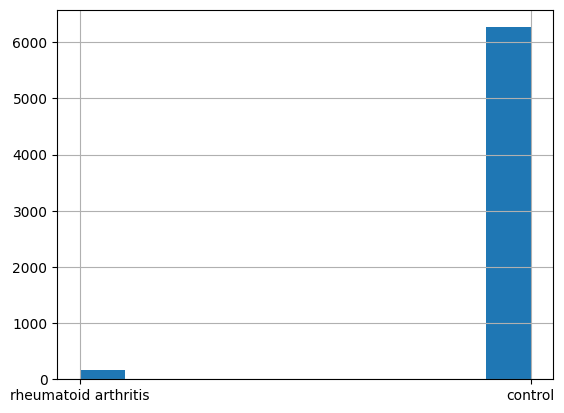

In [7]:
#查看疾病分布
from collections import Counter
print(Counter(Data['disease']))
Data['disease'].hist()

In [8]:
#提取数据
DLRunData=Data.iloc[:,1:-6]
#数据缩放和标准化
from pandas import DataFrame
from sklearn.preprocessing import StandardScaler,MinMaxScaler
FeatureNames=DLRunData.columns    #保存变量名
Standard=StandardScaler()    #标准化数据
StandardData=Standard.fit_transform(DLRunData)
MinMax=MinMaxScaler(feature_range=(0,1))    #缩放数据
MinMaxData=MinMax.fit_transform(StandardData)
MLRunData=DataFrame(MinMaxData)
MLRunData.columns=FeatureNames
MLRunData.shape

(6425, 60)

In [9]:
RunData=pd.concat([MLRunData,Data.loc[:,['GenderEncoder','gender','disease','DiseaseEncoder']]],axis=1)
RunData.shape

(6425, 64)

In [10]:
#分离RA数据和正常患者数据
RAData=RunData.loc[RunData.loc[:,'disease']=='rheumatoid arthritis',:]
RAData.shape

(159, 64)

In [11]:
#提取与类风关相同数量的正常患者数据
ContralData=RunData.loc[RunData.loc[:,'disease']=='control',:]
ContralData.shape

(6266, 64)

In [12]:
#分离DataFrame数据
SampleData=ContralData.sample(frac=1,replace=False,axis=0,random_state=2025).reset_index(drop=True)    #随机排列数据
DNNContralData=SampleData.iloc[:159,:]    #提取用于训练的数据
DNNContralData.shape

(159, 64)

In [13]:
#拼接用于训练DNN的数据：正常组和RA数据各159组
DNNData=pd.concat([RAData,DNNContralData],axis=0)
DNNData.shape

(318, 64)

In [14]:
#提取用于训练编-解码器的数据
EDData=SampleData.iloc[159:,:]
EDData.shape

(6107, 64)

加载Encoder-Dncoder和Encoder

In [ ]:
#加载模型
from tensorflow import keras
Encoder_Dncoder=keras.models.load_model('/mnt/workspace/TestAnalysis Module/AutoEncoder_Dncoder.h5')
AutoEncoder=keras.models.load_model('/mnt/workspace/TestAnalysis Module/AutoEncoder.h5')

In [16]:
#构建数据
EDRunData=EDData.iloc[:,:-4]
EDRunData.shape

(6107, 60)

In [56]:
#数据切分和构建数据输入流
ENTrain=tf.data.Dataset.from_tensor_slices((EDRunData.iloc[:4000,:],EDRunData.iloc[:4000,:])).repeat(50)    #训练集
ENTrain=ENTrain.shuffle(buffer_size=5000,seed=2025).batch(batch_size=1000).prefetch(tf.data.experimental.AUTOTUNE)
ENValid=tf.data.Dataset.from_tensor_slices((EDRunData.iloc[4000:5000,:],EDRunData.iloc[4000:5000,:])).repeat(50)    #验证集
ENValid=ENValid.shuffle(buffer_size=5000,seed=2025).batch(batch_size=1000).prefetch(tf.data.experimental.AUTOTUNE)
ENTest=tf.data.Dataset.from_tensor_slices((EDRunData.iloc[5000:,:],EDRunData.iloc[5000:,:])).repeat(50)    #测试集
ENTest=ENTest.shuffle(buffer_size=5000,seed=2025).batch(batch_size=1000).prefetch(tf.data.experimental.AUTOTUNE)

In [18]:
#评估AME
Encoder_Dncoder.evaluate(ENTest)

56/56 [==============================] - 3s 3ms/step - loss: 0.0243 - mae: 0.0243


[0.024308105930685997, 0.024308105930685997]

使用原始Transformer Encoder 更换LibraFormer Encoder模块。测试原始Transformer Encoder 更换LibraFormer Encoder模块的差异。

In [19]:
#构建DNN数据
from sklearn.model_selection import train_test_split
TrainRAData,LiteRAData,TrainRALabel,LiteRALabel=train_test_split(DNNData.iloc[:,:-4],DNNData.loc[:,'DiseaseEncoder'],train_size=0.6,random_state=2025)
ValidRAData=LiteRAData.iloc[:60,:]    #验证数据集
ValidRALabel=LiteRALabel[:60]
TestRAData=LiteRAData.iloc[60:,:]    #测试数据集
TestRALabel=LiteRALabel[60:]

In [20]:
#构建数据输入流
TrainRA=tf.data.Dataset.from_tensor_slices((TrainRAData,TrainRALabel)).repeat(100)    #训练集数据流
TrainRA=TrainRA.shuffle(buffer_size=5000,seed=2025).batch(batch_size=1000).prefetch(tf.data.experimental.AUTOTUNE)
ValidRA=tf.data.Dataset.from_tensor_slices((ValidRAData,ValidRALabel)).repeat(100)    #验证集数据流
ValidRA=ValidRA.shuffle(buffer_size=5000,seed=2025).batch(batch_size=1000).prefetch(tf.data.experimental.AUTOTUNE)
TestRA=tf.data.Dataset.from_tensor_slices((TestRAData,TestRALabel)).repeat(100)    #测试集数据流
TestRA=TestRA.shuffle(buffer_size=5000,seed=2025).batch(batch_size=1000).prefetch(tf.data.experimental.AUTOTUNE)

In [21]:
#定义位置编码
import numpy as np
class PositionalEncoder(keras.layers.Layer):
    def __init__(self,max_step,max_dims,dtype=tf.float32,**kwargs):
        super().__init__(dtype=dtype,**kwargs)
        self.max_step=max_step
        self.max_dims=max_dims
        if self.max_step%2==1:
            self.max_dims=self.max_dims+1
        p,i=np.meshgrid(np.arange(self.max_step),np.arange(self.max_dims//2))    #生成坐标矩阵
        pos_emb=np.empty((1,self.max_step,self.max_dims))
        pos_emb[0,:,::2]=np.sin(p/10000**(2*i/self.max_dims)).T
        pos_emb[0,:,1::2]=np.cos(p/10000**(2*i/self.max_dims)).T
        self.positial_embedding=tf.constant(pos_emb.astype(self.dtype))
    def call(self,Input):
        shape=tf.shape(Input)
        return Input+self.positial_embedding[:shape[-2],:shape[-1]]
    def compute_output_shape(self):    #规范输出维度
        return tf.TensorShape([20,24])
    def get_config(self):
        Basconfig = super().get_config()
        return {**Basconfig,'max_step':self.max_step,'max_dims':self.max_dims}

In [22]:
#构建TransFormer Encoder
from tensorflow import keras
class TransformerEncoder(keras.layers.Layer):
    def __init__(self,heads,key_dim,input_dim,Wdim,**kwargs):
        super().__init__(**kwargs)
        self.heads=heads    #注意力头数
        self.key_d=key_dim    #Key维度
        self.input_dim=input_dim    #输入数据维度
        self.Wdim=Wdim    #矩阵维度
        self.Multi_Head_Attention=keras.layers.MultiHeadAttention(num_heads=self.heads,key_dim=self.key_d)    #自注意力
        self.LayerNormaltion=keras.layers.LayerNormalization()    #层归一化
        self.LinearLayer=keras.layers.Dense(input_dim=self.input_dim,units=self.Wdim,activation=None,use_bias=False)    #线性层
        self.Leaky_Relu=keras.layers.LeakyReLU(alpha=0.01)    #使用LeakyRelu激活函数
        self.LinearActivation=keras.layers.Dense(input_dim=self.input_dim,units=self.Wdim,activation='selu',
                                                 kernel_initializer=None,use_bias=False)    #使用SELU激活函数的线性层
        self.AddLayer=keras.layers.Add()    #相加层
    def call(self,Input):    #前向计算
        MSA=self.Multi_Head_Attention(query=Input,value=Input,key=Input)    #计算Multi-Head-attention
        ResNet=self.AddLayer([MSA,Input])    #残差连接
        ResNormaltion=self.LayerNormaltion(ResNet)    #层归一化
        LinearActiontion=self.LinearActivation(ResNormaltion)
        LinearOutput=self.LinearLayer(LinearActiontion)
        ResNet2=self.AddLayer([LinearOutput,ResNormaltion])
        Res2Normaltion=self.LayerNormaltion(ResNet2)    #层归一化
        return Res2Normaltion
    def compute_output_shape(self):    #规范输出维度
        return tf.TensorShape([self.input_dim,self.Wdim])
    def get_config(self):
        Base_config=super().get_config()
        return {**Base_config,'heads':self.heads,'key_dim':self.key_d,'input_dim':self.input_dim,'Wdim':self.Wdim}

In [29]:
#模型组网
DNNClass=keras.models.Sequential([])
DNNClass.add(keras.layers.Input(shape=(20,24),name='Input_Dncoder'))
DNNClass.add(PositionalEncoder(max_step=20,max_dims=24))
DNNClass.add(TransformerEncoder(heads=8,key_dim=24,input_dim=20,Wdim=24))
DNNClass.add(TransformerEncoder(heads=8,key_dim=24,input_dim=20,Wdim=24))
DNNClass.add(TransformerEncoder(heads=8,key_dim=24,input_dim=20,Wdim=24))
DNNClass.add(TransformerEncoder(heads=8,key_dim=24,input_dim=20,Wdim=24))
DNNClass.add(TransformerEncoder(heads=8,key_dim=24,input_dim=20,Wdim=24))
DNNClass.add(TransformerEncoder(heads=8,key_dim=24,input_dim=20,Wdim=24))
DNNClass.add(TransformerEncoder(heads=8,key_dim=24,input_dim=20,Wdim=24))
DNNClass.add(TransformerEncoder(heads=8,key_dim=24,input_dim=20,Wdim=24))
DNNClass.add(TransformerEncoder(heads=8,key_dim=24,input_dim=20,Wdim=24))
DNNClass.add(TransformerEncoder(heads=8,key_dim=24,input_dim=20,Wdim=24))
DNNClass.add(keras.layers.Flatten()) 
DNNClass.add(keras.layers.BatchNormalization())
DNNClass.add(keras.layers.Dense(360,activation='relu',kernel_initializer='lecun_normal',kernel_regularizer=keras.regularizers.l1_l2(0.05,0.05),
                   kernel_constraint=keras.constraints.max_norm(1)))
DNNClass.add(keras.layers.Dropout(rate=0.5))
DNNClass.add(keras.layers.Dense(360,activation='relu',kernel_initializer='lecun_normal',kernel_regularizer=keras.regularizers.l1_l2(0.05,0.05),
                   kernel_constraint=keras.constraints.max_norm(1)))
DNNClass.add(keras.layers.BatchNormalization())
DNNClass.add(keras.layers.Dense(120,activation='relu',kernel_initializer='lecun_normal',kernel_regularizer=keras.regularizers.l1_l2(0.05,0.05),
                   kernel_constraint=keras.constraints.max_norm(1)))
DNNClass.add(keras.layers.Dropout(rate=0.5))
DNNClass.add(keras.layers.Dense(120,activation='relu',kernel_initializer='lecun_normal',kernel_regularizer=keras.regularizers.l1_l2(0.05,0.05),
                   kernel_constraint=keras.constraints.max_norm(1)))
DNNClass.add(keras.layers.BatchNormalization())
DNNClass.add(keras.layers.Dense(60,activation='relu',kernel_initializer='lecun_normal',kernel_regularizer=keras.regularizers.l1_l2(0.05,0.05),
                   kernel_constraint=keras.constraints.max_norm(1)))
DNNClass.add(keras.layers.Dropout(rate=0.5))
DNNClass.add(keras.layers.Dense(30,activation='relu',kernel_initializer='lecun_normal',kernel_regularizer=keras.regularizers.l1_l2(0.05,0.05),
                   kernel_constraint=keras.constraints.max_norm(1)))
DNNClass.add(keras.layers.BatchNormalization())
DNNClass.add(keras.layers.Dense(15,activation='relu',kernel_initializer='lecun_normal',kernel_regularizer=keras.regularizers.l1_l2(0.05,0.05),
                   kernel_constraint=keras.constraints.max_norm(1)))
DNNClass.add(keras.layers.Dense(1,activation='sigmoid',name='Output_Class'))
DNNClass.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 positional_encoder_1 (Posi  (None, 20, 24)            0         
 tionalEncoder)                                                  
                                                                 
 transformer_encoder_10 (Tr  (None, 20, 24)            20232     
 ansformerEncoder)                                               
                                                                 
 transformer_encoder_11 (Tr  (None, 20, 24)            20232     
 ansformerEncoder)                                               
                                                                 
 transformer_encoder_12 (Tr  (None, 20, 24)            20232     
 ansformerEncoder)                                               
                                                                 
 transformer_encoder_13 (Tr  (None, 20, 24)           

In [31]:
#模型组网
for layer in AutoEncoder.layers:    #将编码器设置为不可训练模式 
    layer.trainable=False
AutoDNN=keras.models.Sequential([AutoEncoder,DNNClass])
AutoDNN.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                metrics=[keras.metrics.AUC()])

In [32]:
#添加TensorBoard回调
import os,time
logs_dir=os.path.join('logs/fit/','AutoDNN_Logs')
def Get_logdir():
    Now_time=time.strftime('run_%Y_%m_%d_%H-%M-%S')
    return os.path.join(logs_dir,Now_time)
Auto_Rundir=Get_logdir()

In [33]:
#训练模型训练 
AutoTrainEpochs=100
AutoTensorBoard=keras.callbacks.TensorBoard(Auto_Rundir,histogram_freq=1)
AutoLrSchudue=keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=25)    #学习率性能调度
AutoCheckPoint=keras.callbacks.ModelCheckpoint(filepath='/mnt/workspace/Encoder_Dncoder/ResFormer/Train History/AutoDNN.h5',
                                                      monitor='val_auc',mode='max',save_best_only=True,save_weights_only=False)    #设置检查点
AutoEarlyStoping=keras.callbacks.EarlyStopping(patience=100,monitor='val_auc',restore_best_weights=True)    #设置提前停止
AutoTrainHistory=AutoDNN.fit(TrainRA,epochs=AutoTrainEpochs,validation_data=(ValidRA),
                             callbacks=[AutoLrSchudue,AutoCheckPoint,AutoEarlyStoping,AutoTensorBoard])

Epoch 1/100


2025-02-05 09:58:17.338843: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8900
2025-02-05 09:58:18.873381: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f57c0191b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-05 09:58:18.873405: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A10, Compute Capability 8.6
2025-02-05 09:58:18.883380: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-05 09:58:18.983741: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 [==============================] - 34s 247ms/step - loss: 818.0269 - auc: 0.4719 - val_loss: 797.7104 - val_auc: 0.6484 - lr: 1.0000e-04
Epoch 2/100
19/19 [==============================] - 2s 121ms/step - loss: 780.5199 - auc: 0.5108 - val_loss: 761.4142 - val_auc: 0.4118 - lr: 1.0000e-04
Epoch 3/100
19/19 [==============================] - 2s 121ms/step - loss: 744.7261 - auc: 0.5461 - val_loss: 726.2454 - val_auc: 0.4838 - lr: 1.0000e-04
Epoch 4/100
19/19 [==============================] - 2s 122ms/step - loss: 710.0814 - auc: 0.5841 - val_loss: 692.2353 - val_auc: 0.6161 - lr: 1.0000e-04
Epoch 5/100
19/19 [==============================] - 2s 133ms/step - loss: 676.5825 - auc: 0.6328 - val_loss: 659.3664 - val_auc: 0.6802 - lr: 1.0000e-04
Epoch 6/100
19/19 [==============================] - 2s 133ms/step - loss: 644.2193 - auc: 0.6640 - val_loss: 627.6138 - val_auc: 0.6808 - lr: 1.0000e-04
Epoch 7/100
19/19 [==============================] - 2s 134ms/step - loss: 612.9543 - a

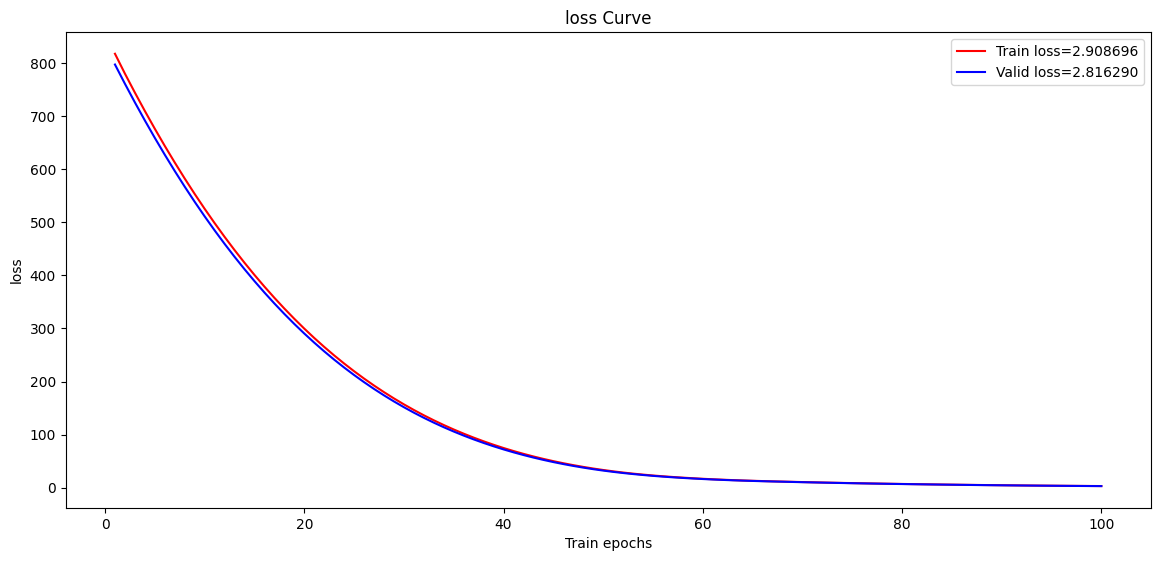

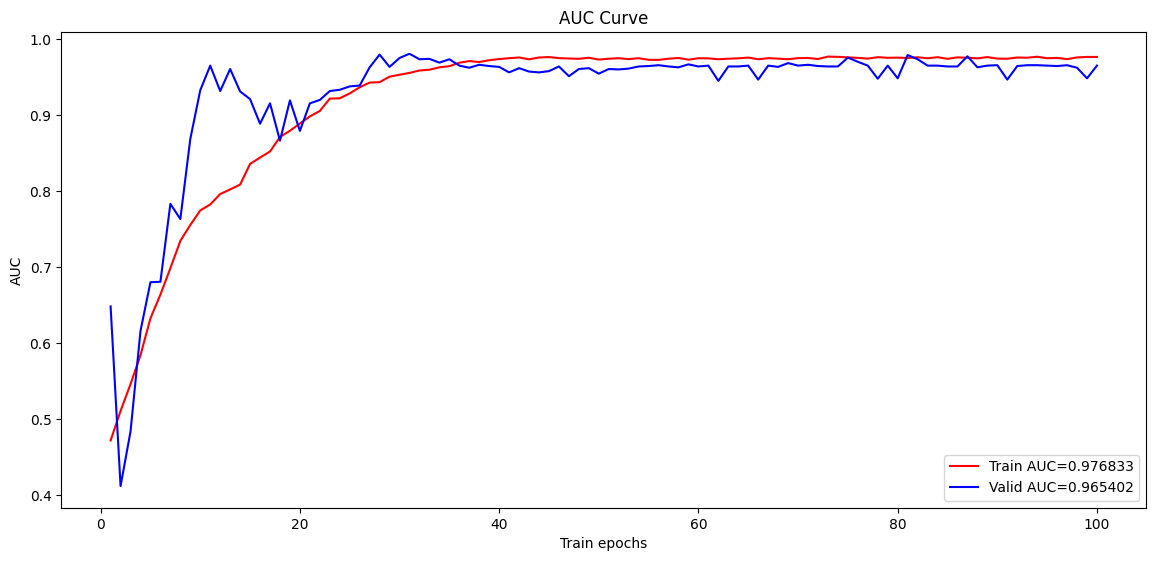

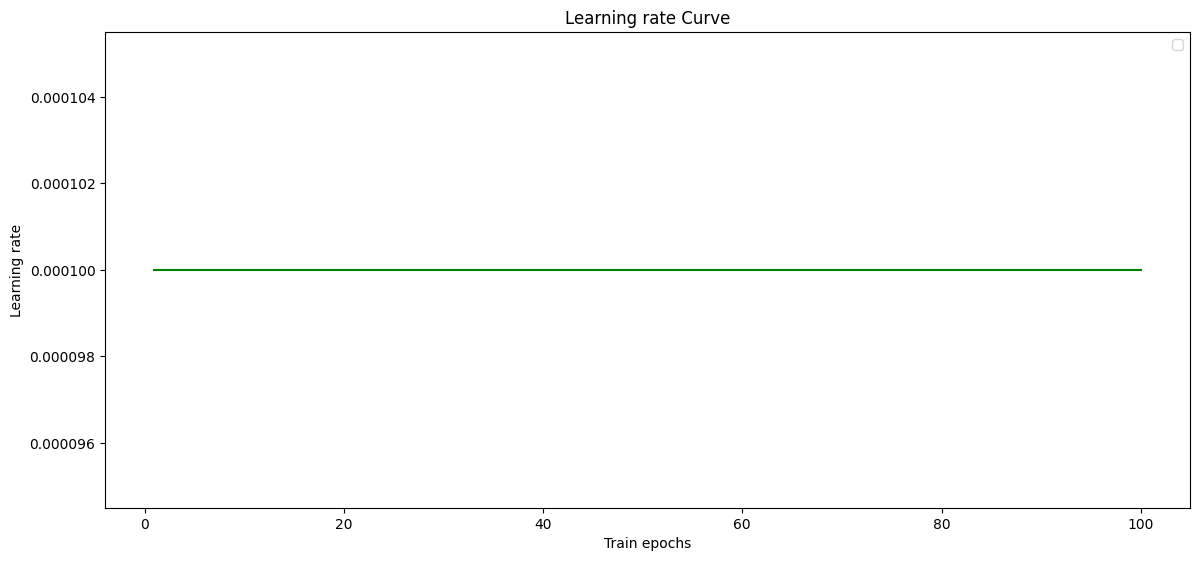

In [34]:
#绘制训练曲线
import matplotlib.pyplot as plt
from pandas import DataFrame
AutoHistory=DataFrame(AutoTrainHistory.history)
Epoch=AutoHistory.shape[0]
import numpy as np
fig=plt.figure(figsize=(14,21)) 
ax1=fig.add_subplot(311) #绘制误差曲线 
ax1.set_title('loss Curve') 
#ax1.grid(color='black',linestyle='-.',alpha=0.3) 
ax1.plot(np.arange(1,Epoch+1),AutoHistory['loss'],
         color='red',linestyle='-',label='Train loss=%f'%AutoHistory.loc[Epoch-1,'loss']) 
ax1.plot(np.arange(1,Epoch+1),AutoHistory['val_loss'],
         color='blue',linestyle='-',label='Valid loss=%f'%AutoHistory.loc[Epoch-1,'val_loss']) 
ax1.set_xlabel('Train epochs') 
ax1.set_ylabel('loss') 
ax1.legend() 
fig2=plt.figure(figsize=(14,21)) 
ax2=fig2.add_subplot(312) #绘制精度曲线 
ax2.set_title('AUC Curve') 
#ax2.grid(color='black',linestyle='-.',alpha=0.3) 
ax2.plot(np.arange(1,Epoch+1),AutoHistory.iloc[:,1],
         color='red',linestyle='-',label='Train AUC=%f'%AutoHistory.iloc[Epoch-1,1]) 
ax2.plot(np.arange(1,Epoch+1),AutoHistory.iloc[:,3],
         color='blue',linestyle='-',label='Valid AUC=%f'%AutoHistory.iloc[Epoch-1,3]) 
ax2.set_xlabel('Train epochs') 
ax2.set_ylabel('AUC') 
ax2.legend()
fig3=plt.figure(figsize=(14,21)) 
ax3=fig3.add_subplot(313) #绘制精度曲线 
ax3.set_title('Learning rate Curve') 
#ax3.grid(color='black',linestyle='-.',alpha=0.3) 
ax3.plot(np.arange(1,Epoch+1),AutoHistory['lr'],color='green',linestyle='-') 
ax3.set_xlabel('Train epochs') 
ax3.set_ylabel('Learning rate') 
ax3.legend()

In [35]:
AutoDNN.evaluate(TestRA)

7/7 [==============================] - 0s 27ms/step - loss: 2.8693 - auc: 0.9319


[2.8693463802337646, 0.9318576455116272]

In [36]:
#模型评估函数
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
def TestDNN(Model,Data,Label):
    #数据转化
    PredictLabel=[]
    Predict_Proba=Model.predict(Data)
    for proba in Predict_Proba:
        if proba<=0.5:
            PredictLabel.append(0)
        elif proba>0.5:
            PredictLabel.append(1)
    TestPrecision=precision_score(Label,PredictLabel)
    TestRecall=recall_score(Label,PredictLabel)
    TestF1=f1_score(Label,PredictLabel)
    TestAccuracy=accuracy_score(Label,PredictLabel)
    print('模型测试集Precision:{0},Recall:{1},F1_score:{2},Accuracy:{3}'.format(TestPrecision,TestRecall,TestF1,TestAccuracy))
    print('-------------------测试集混淆举证-------------------')
    ConfusionMatrix_result=confusion_matrix(Label,PredictLabel,labels=[0,1])    #计算混淆举证
    Display_ConfusionMatrix=ConfusionMatrixDisplay(ConfusionMatrix_result,display_labels=['control','rheumatoid arthritis'])
    Display_ConfusionMatrix.plot(include_values=True, cmap='viridis', xticks_rotation='horizontal', values_format='d', ax=None)
    plt.title('Confusion Matrix')
    plt.show()

6/6 [==============================] - 0s 9ms/step
模型测试集Precision:0.9782608695652174,Recall:0.989010989010989,F1_score:0.9836065573770492,Accuracy:0.9842105263157894
-------------------测试集混淆举证-------------------


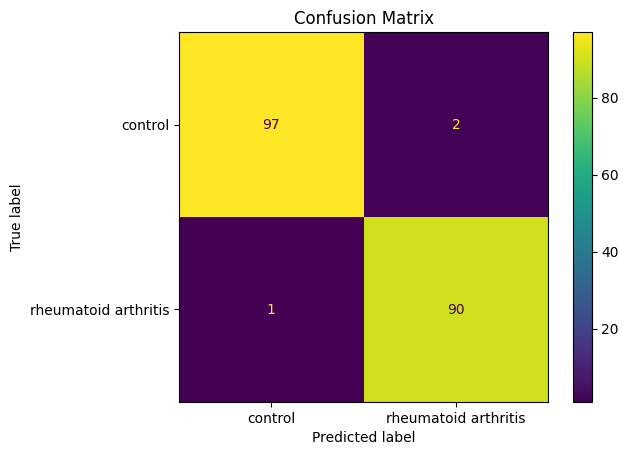

In [52]:
TestDNN(Model=AutoDNN,Data=TrainRAData,Label=TrainRALabel)    #训练集

2/2 [==============================] - 0s 10ms/step
模型测试集Precision:0.9393939393939394,Recall:0.96875,F1_score:0.9538461538461539,Accuracy:0.95
-------------------测试集混淆举证-------------------


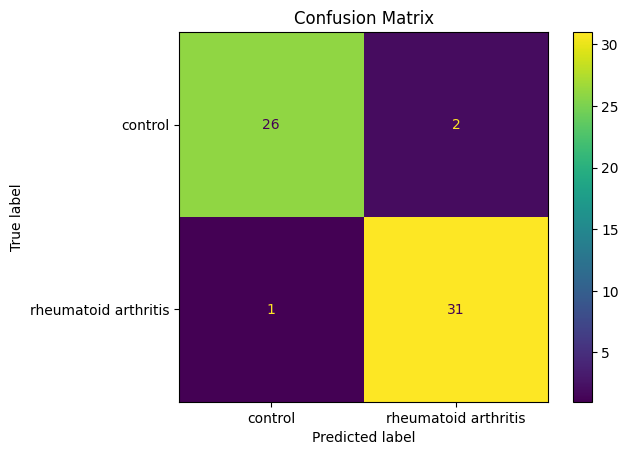

In [53]:
TestDNN(Model=AutoDNN,Data=ValidRAData,Label=ValidRALabel)    #验证集

3/3 [==============================] - 0s 9ms/step
模型测试集Precision:0.8717948717948718,Recall:0.9444444444444444,F1_score:0.9066666666666666,Accuracy:0.8970588235294118
-------------------测试集混淆举证-------------------


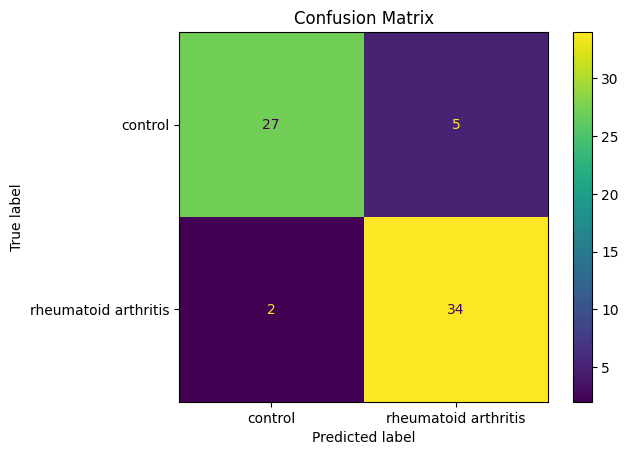

In [54]:
TestDNN(Model=AutoDNN,Data=TestRAData,Label=TestRALabel)

In [ ]:
#保存模型
AutoDNN.save('/mnt/workspace/Model test Module/AutoDNN.h5')
AutoDNN.save('/mnt/workspace/Model test Module/AutoDNN')

In [39]:
#计算PR曲线
from pandas import DataFrame
from sklearn.metrics import precision_recall_curve,accuracy_score
def PR_Curve(Model,Data,Label):
    X_train,X_test,y_train,y_test=train_test_split(Data,Label,train_size=0.7,random_state=2025)    #划分数据集
    predict_score=Model.predict(X_test)[:, 0]    #获取概率值
    #数据转化
    PredictLabel=[]
    for proba in predict_score:
        if proba<=0.5:
            PredictLabel.append(0)
        elif proba>0.5:
            PredictLabel.append(1)
    accuracy=accuracy_score(y_test,PredictLabel)
    precision, recall, thresholds = precision_recall_curve(y_test, predict_score)    #计算PR曲线
    PR=DataFrame()    #将PR曲线数据合并到DataFrame
    #PR['thresholds']=thresholds
    PR['recall']=recall
    PR['precision']=precision
    return PR,accuracy

In [40]:
#计算模型PR曲线
AutoDNN_PR,AutoDNN_Accuracy=PR_Curve(Model=AutoDNN,Data=TestRAData,Label=TestRALabel)

1/1 [==============================] - 0s 24ms/step


In [41]:
#读取测试机器学习模型PR曲线数据
ReLogistic_PR=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML PR Curve/Logistic_PR.xlsx','UTF-8')
ReLogistic_PR=ReLogistic_PR.iloc[:,1:]
ReSVM_PR=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML PR Curve/ReSVM_PR.xlsx','UTF-8')
ReSVM_PR=ReSVM_PR.iloc[:,1:]
ReDTC_PR=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML PR Curve/ReDTC_PR.xlsx','UTF-8')
ReDTC_PR=ReDTC_PR.iloc[:,1:]
ReRondomForest_PR=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML PR Curve/ReRondomForest_PR.xlsx','UTF-8')
ReRondomForest_PR=ReRondomForest_PR.iloc[:,1:]
ReXGBoost_PR=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML PR Curve/ReXGBoost_PR.xlsx','UTF-8')
ReXGBoost_PR=ReXGBoost_PR.iloc[:,1:]
ReLightGBM_PR=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML PR Curve/ReLightGBM_PR.xlsx','UTF-8')
ReLightGBM_PR=ReLightGBM_PR.iloc[:,1:]
ReCatBoost_PR=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML PR Curve/ReCatBoost_PR.xlsx','UTF-8')
ReCatBoost_PR=ReCatBoost_PR.iloc[:,1:]
LibraFormer_PR=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML PR Curve/LibraFormer_PR.xlsx','UTF-8')
LibraFormer_PR=LibraFormer_PR.iloc[:,1:]

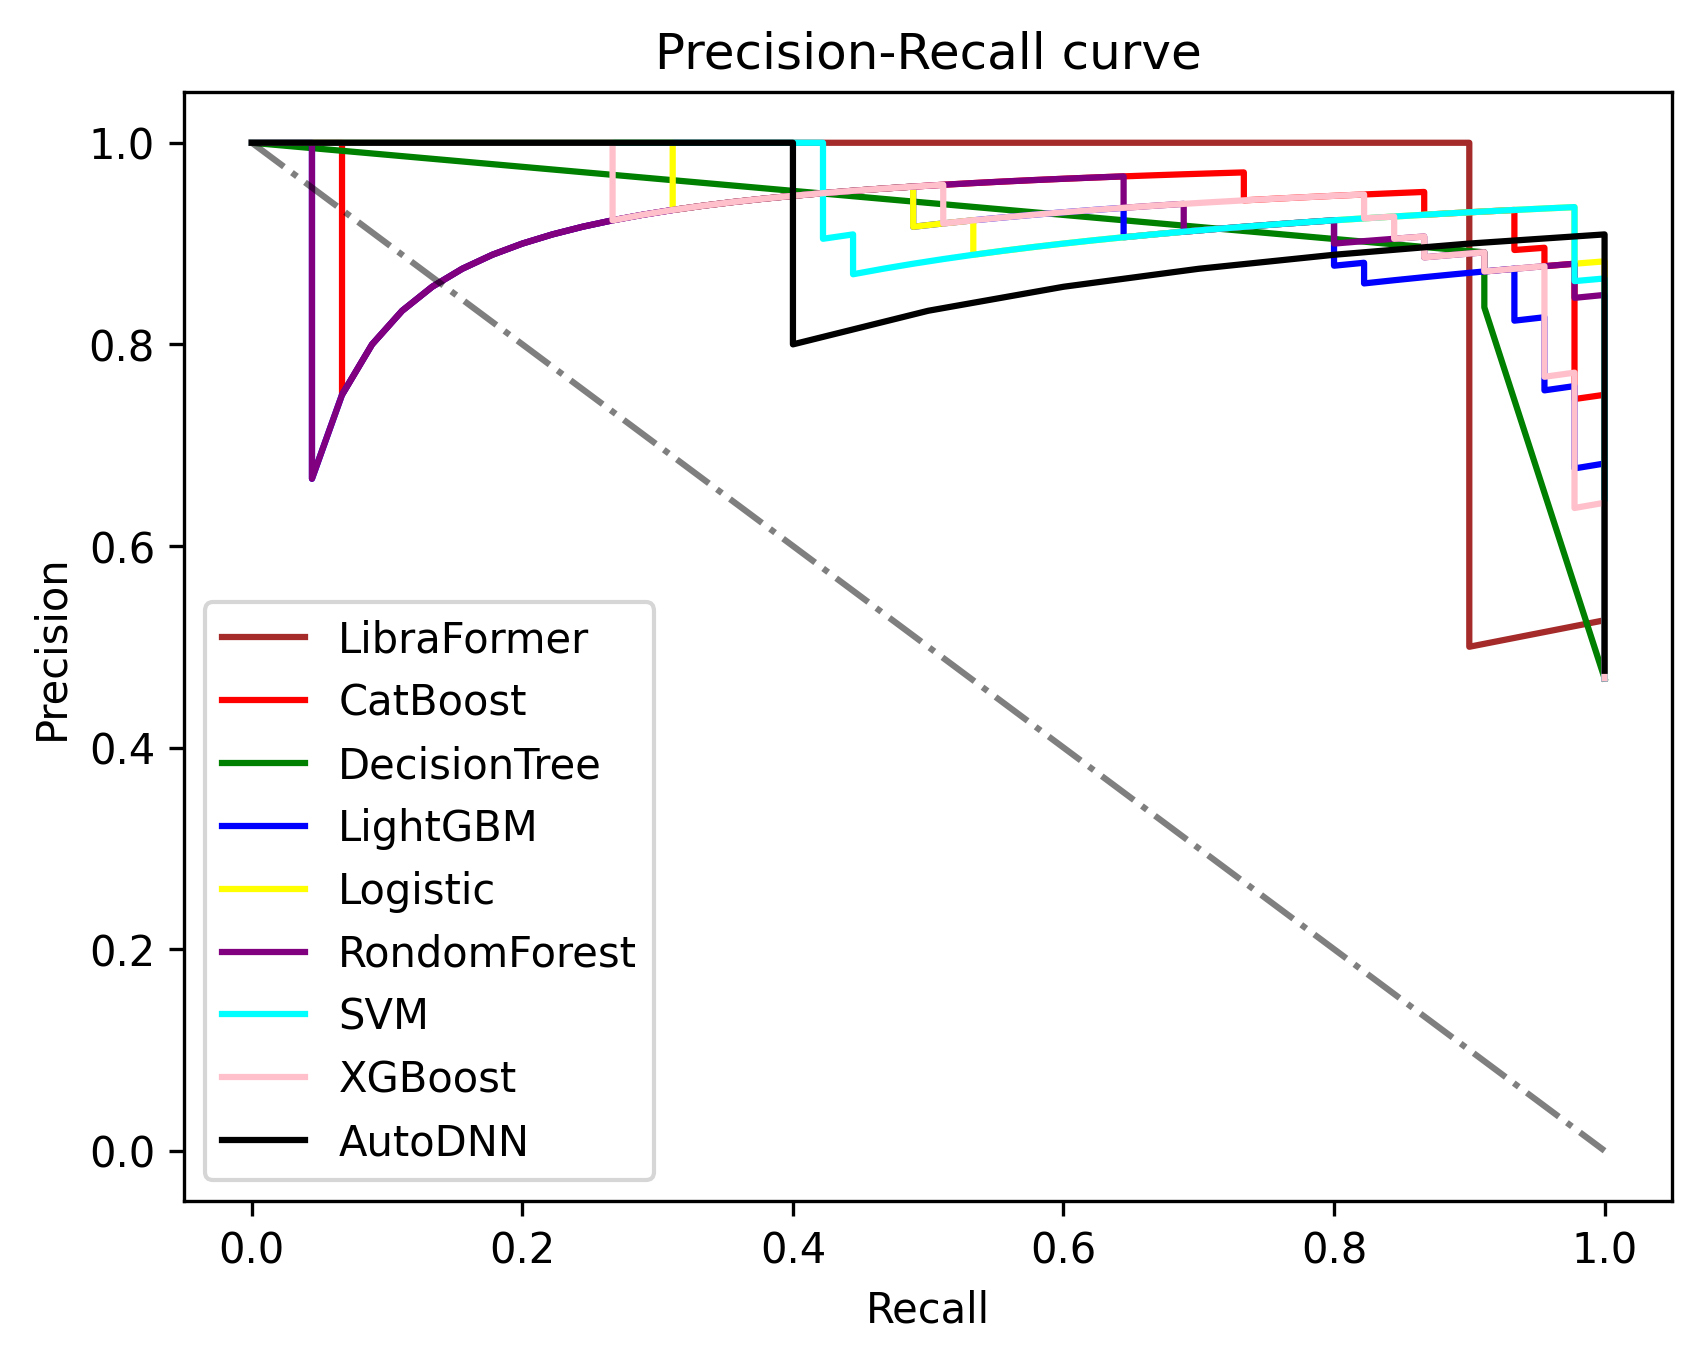

In [44]:
#绘制PR曲线
import matplotlib.pyplot as plt
PR_curve=plt.figure(dpi=300)
PR_ax=PR_curve.add_subplot(111)
PR_ax.set_title('Precision-Recall curve')
PR_ax.plot(LibraFormer_PR['recall'], LibraFormer_PR['precision'],color='brown',label='LibraFormer')
PR_ax.plot(ReCatBoost_PR['recall'], ReCatBoost_PR['precision'],color='red',label='CatBoost')
PR_ax.plot(ReDTC_PR['recall'], ReDTC_PR['precision'],color='green',label='DecisionTree')
PR_ax.plot(ReLightGBM_PR['recall'], ReLightGBM_PR['precision'],color='blue',label='LightGBM')
PR_ax.plot(ReLogistic_PR['recall'], ReLogistic_PR['precision'],color='yellow',label='Logistic')
PR_ax.plot(ReRondomForest_PR['recall'], ReRondomForest_PR['precision'],color='purple',label='RondomForest')
PR_ax.plot(ReSVM_PR['recall'], ReSVM_PR['precision'],color='cyan',label='SVM')
PR_ax.plot(ReXGBoost_PR['recall'], ReXGBoost_PR['precision'],color='pink',label='XGBoost')
PR_ax.plot(AutoDNN_PR['recall'], AutoDNN_PR['precision'],color='black',label='AutoDNN')
PR_ax.plot([0,1],[1,0],linestyle='-.',color='black',alpha=0.5)
PR_ax.set_xlabel('Recall')  
PR_ax.set_ylabel('Precision')    
plt.legend(loc="best")  
plt.show()

In [45]:
#计算ROC曲线
from sklearn.metrics import roc_curve, auc
def ROC_Curve(Model,Data,Label):
    X_train,X_test,y_train,y_test=train_test_split(Data,Label,train_size=0.7,random_state=2025)    #划分数据集
    predict_score=Model.predict(X_test)[:, 0]    #获取概率值
    fpr, tpr, thresholds = roc_curve(y_test, predict_score)
    roc_auc = auc(fpr, tpr)    #计算AUC
    ROC=DataFrame()    #将PR曲线数据合并到DataFrame
    #ROC['thresholds']=thresholds
    ROC['tpr']=tpr
    ROC['fpr']=fpr
    return ROC,roc_auc

In [46]:
AutoDNN_ROC,AutoDNN_AUC=ROC_Curve(Model=AutoDNN,Data=TestRAData,Label=TestRALabel)    #计算LibraFormer模型ROC曲线

1/1 [==============================] - 0s 22ms/step


In [48]:
#读取测试机器学习模型ROC曲线数据
ReLogistic_ROC=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML ROC Curve/Logistic_ROC.xlsx','UTF-8')
ReLogistic_ROC=ReLogistic_ROC.iloc[:,1:]
ReSVM_ROC=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML ROC Curve/ReSVM_ROC.xlsx','UTF-8')
ReSVM_ROC=ReSVM_ROC.iloc[:,1:]
ReDTC_ROC=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML ROC Curve/ReDTC_ROC.xlsx','UTF-8')
ReDTC_ROC=ReDTC_ROC.iloc[:,1:]
ReRondomForest_ROC=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML ROC Curve/ReRondomForest_ROC.xlsx','UTF-8')
ReRondomForest_ROC=ReRondomForest_ROC.iloc[:,1:]
ReXGBoost_ROC=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML ROC Curve/ReXGBoost_ROC.xlsx','UTF-8')
ReXGBoost_ROC=ReXGBoost_ROC.iloc[:,1:]
ReLightGBM_ROC=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML ROC Curve/ReLightGBM_ROC.xlsx','UTF-8')
ReLightGBM_ROC=ReLightGBM_ROC.iloc[:,1:]
ReCatBoost_ROC=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML ROC Curve/ReCatBoost_ROC.xlsx','UTF-8')
ReCatBoost_ROC=ReCatBoost_ROC.iloc[:,1:]
LibraFormer_ROC=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML ROC Curve/LibraFormer_ROC.xlsx','UTF-8')
LibraFormer_ROC=LibraFormer_ROC.iloc[:,1:]

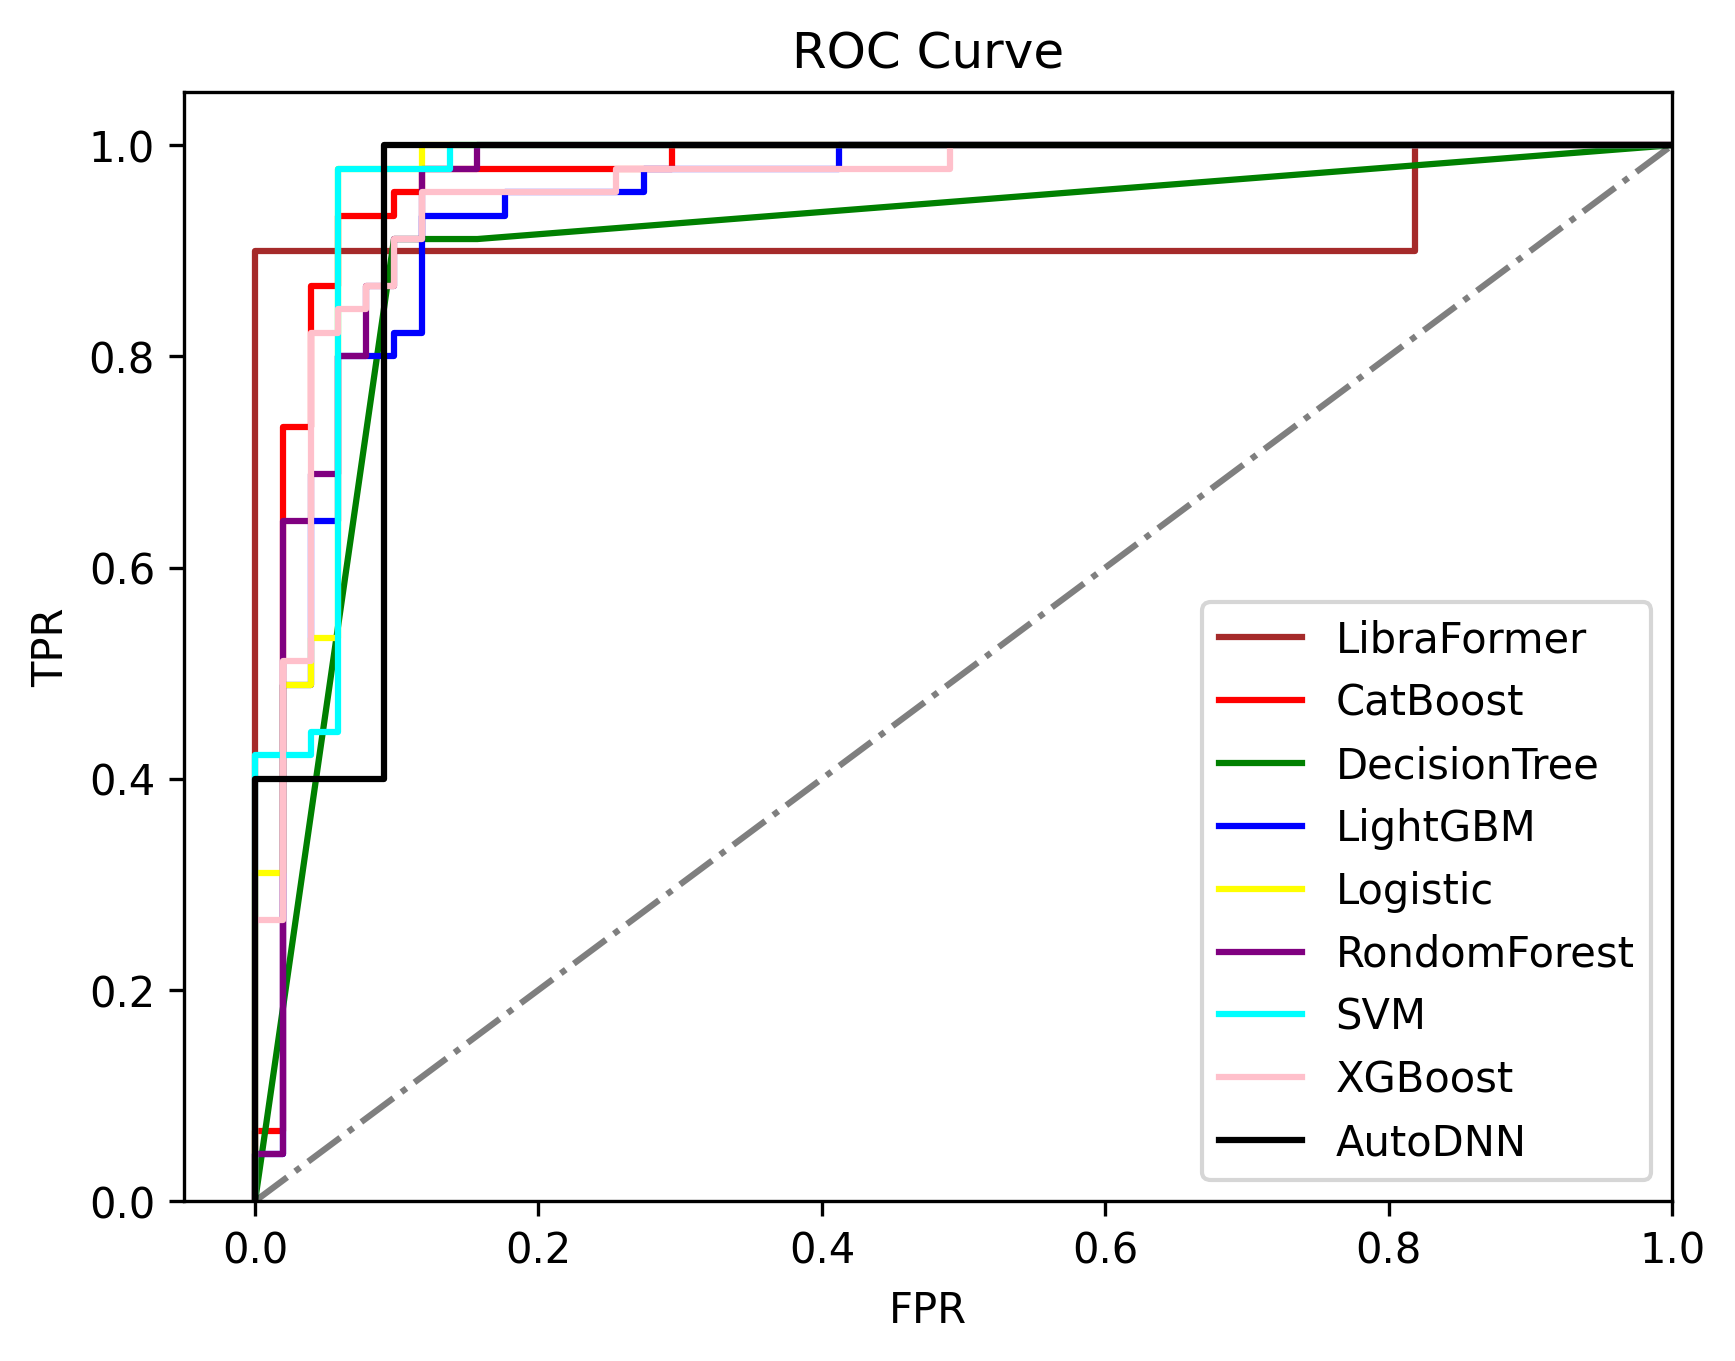

In [50]:
#绘制ROC曲线
import matplotlib.pyplot as plt
ROC_curve=plt.figure(dpi=300)
ROC_ax=ROC_curve.add_subplot(111)
ROC_ax.set_title('ROC Curve')
ROC_ax.plot(LibraFormer_ROC['fpr'], LibraFormer_ROC['tpr'],color='brown',label='LibraFormer')
ROC_ax.plot(ReCatBoost_ROC['fpr'], ReCatBoost_ROC['tpr'],color='red',label='CatBoost')
ROC_ax.plot(ReDTC_ROC['fpr'], ReDTC_ROC['tpr'],color='green',label='DecisionTree')
ROC_ax.plot(ReLightGBM_ROC['fpr'], ReLightGBM_ROC['tpr'],color='blue',label='LightGBM')
ROC_ax.plot(ReLogistic_ROC['fpr'], ReLogistic_ROC['tpr'],color='yellow',label='Logistic')
ROC_ax.plot(ReRondomForest_ROC['fpr'], ReRondomForest_ROC['tpr'],color='purple',label='RondomForest')
ROC_ax.plot(ReSVM_ROC['fpr'], ReSVM_ROC['tpr'],color='cyan',label='SVM')
ROC_ax.plot(ReXGBoost_ROC['fpr'], ReXGBoost_ROC['tpr'],color='pink',label='XGBoost')
ROC_ax.plot(AutoDNN_ROC['fpr'], AutoDNN_ROC['tpr'],color='black',label='AutoDNN')
ROC_ax.plot([0,1],[0,1],linestyle='-.',color='black',alpha=0.5)
ROC_ax.set_xlim([-0.05, 1.0])  
ROC_ax.set_ylim([0, 1.05])  
ROC_ax.set_xlabel('FPR')  
ROC_ax.set_ylabel('TPR')    
plt.legend(loc="best")  
plt.show()

In [51]:
#保存PR曲线和ROC曲线
AutoDNN_PR.to_excel('/mnt/workspace/Model test Module/Resample Data/ML PR Curve/AutoDNN_PR.xlsx','UTF-8')
AutoDNN_ROC.to_excel('/mnt/workspace/Model test Module/Resample Data/ML ROC Curve/AutoDNN_ROC.xlsx','UTF-8')